**Objective**: Show understanding of creating data pipelines and transformations.

**Tasks**:
- Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.
- Calculate MACD (slow/medium/fast) and RSI for each metal historically.
- Use SQL inserts to populate the SQL table created in Question 2 with this generated data.
- Demonstrate the use of a decorator to log the execution of the SQL inserts.

# Task: Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.

In [1]:
import pandas as pd
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker, DeclarativeBase
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
from functools import wraps

We'll start by using code from Question 1 to filter out exporting Copper and Zinc prices for the year 2020 and 2021 from `MarketData.csv`. Then, we'll export this data as `MarketData_filtered.csv` as a checkpoint.

In [2]:
# Import csv data
df = pd.read_csv('../data/MarketData.csv', skiprows=6) # Skip the first 6 rows
df.columns = ['Dates', 'COPPER', 'ALUMINUM', 'ZINC', 'LEAD', 'TIN', 'Genric Future']

# Set Dates columns as index and change data type
df = df.set_index('Dates')
df.index = pd.to_datetime(df.index)

# Sort Dates index by ascending order
df.sort_index(ascending=True, inplace=True)

# Filter data for the year 2020 and 2021 for "Copper" and "Zinc"
df_20_21=df.loc[(df.index < '01-01-2022') & (df.index >= '01-01-2020')]

# Filter columns 'Copper' and 'Zinc'.
labels = ['COPPER', 'ZINC']
df_filtered = df_20_21.loc[:, labels]
print(df_filtered)

# Save as csv as checkpoint
df_filtered.to_csv("./MarketData_filtered.csv")
print("csv exported successfully.")

            COPPER    ZINC
Dates                     
2020-01-01  6174.0  2272.0
2020-01-04  4800.0  1870.5
2020-01-05  5110.0  1913.5
2020-01-06  5484.0  2022.0
2020-01-07  6061.0  2041.5
...            ...     ...
2021-12-27  9568.0  3519.0
2021-12-28  9568.0  3519.0
2021-12-29  9680.5  3513.0
2021-12-30  9691.5  3532.5
2021-12-31  9720.5  3534.0

[523 rows x 2 columns]
csv exported successfully.


# Task: Calculate MACD and RSI for each metal historically. Then, use SQL inserts to populate the SQL table created in Question 2 with this generated data.


## Overview of data pipeline design

### Import data from csv
- The pipeline starts by loading data from `MarketData_filtered.csv` for analysis and manipulation.
### Calculate MACD and RSI
- Once the data is loaded into the DataFrame, the pipeline proceeds to calculate Moving average convergence/divergence (MACD) and Relative Strength Index (RSI) values for each metal.
- MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. The signal line is based on 9-period EMA of MACD.
- RSI is defined as average gain and average loss over a 14-period window.
### Inserting Processed Data into SQL Table
- After calculating MACD and RSI values, the pipeline inserts the processed data back into an SQL table for storage and future retrieval.
- A decorator is applied to log the execution of SQL inserts for monitoring and debugging purposes.
### Data consistency
- Throughout the pipeline, SQLAlchemy's ORM features are used to isolate database operations and protect database from injection attacks.

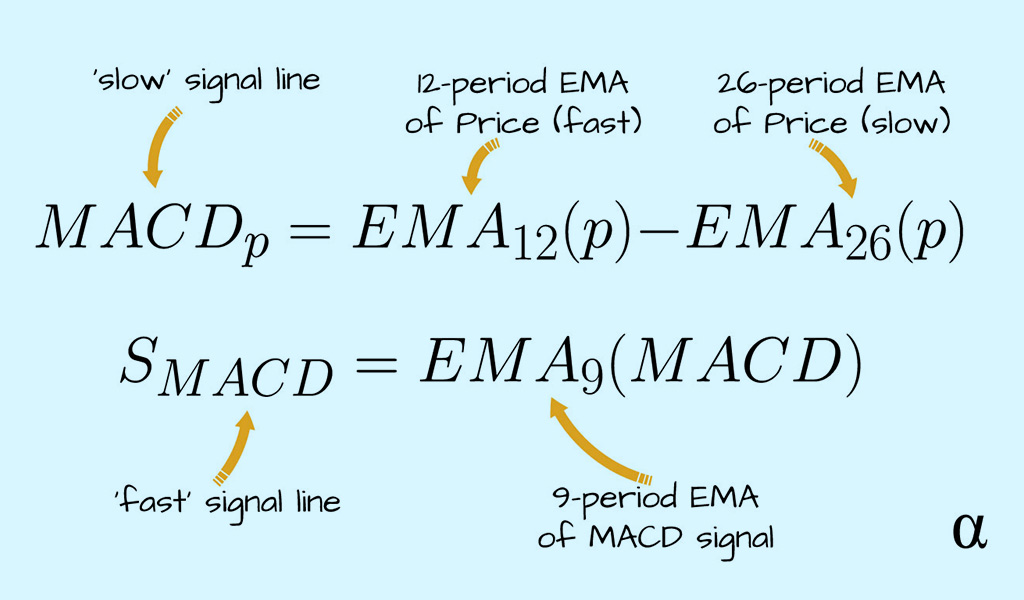

ref: https://www.truedata.in/blog/what-is-macd-all-you-need-to-know/

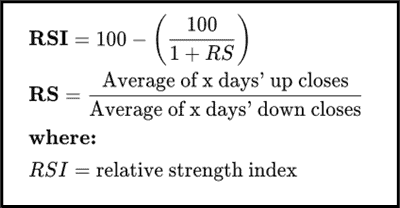

ref: https://www.truedata.in/blog/what-is-macd-all-you-need-to-know/

## Implementation

To begin, we'll configure logging to save logging into `sql_inserts_Q3.log`. We'll also define a decorator `log_sql_insert` to log SQL inserts. Here, the `@wraps(func)` is used to retain metadata of the functions such as function name, docstring, and signature. This helps with debugging purposes.

In [3]:
# Configure logging
logging.basicConfig(filename='sql_inserts_Q3.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

# Define decorator to log SQL inserts
def log_sql_insert(func):
    @wraps(func)    # Preserve metadata of original function, helps debugging
    def wrapper(*args, **kwargs):
        start_time = datetime.now()
        result = func(*args, **kwargs)
        end_time = datetime.now()
        execution_time = end_time - start_time
        logging.info(f"SQL insert executed in {execution_time.total_seconds()} seconds")
        return result
    return wrapper

Next, we'll configure SQLAlchemy engine (using `sqlite`) and redefine `MetalPrice` class using the one-table schema in Question 2. Here, we've reused the code from Question 2 to maintain consistency within this notebook. In a real-world scenario, it's best practice to encapsulate this code in a standalone .py file to avoid redundancy.

In [4]:
# Define SQLAlchemy engine
engine = create_engine('sqlite:///metal_commodity.db')

# Define Base class for declarative ORM
class Base(DeclarativeBase):
    pass

# Define MetalPrice ORM class
class MetalPrice(Base):
    __tablename__ = 'metal_prices'

    id = Column(Integer, primary_key=True)
    date = Column(Date)
    metal = Column(String)
    price = Column(Float)
    macd = Column(Float)
    macd_signal = Column(Float)
    rsi = Column(Float)

Next, we'll define functions to calculate MACD and RSI.
- `calculate_macd` calculates the MACD for a given series of `prices`. The function calculates the EMAs of the prices using the `ewm()` method in pandas to calculate the exponential weighted calculations, and `mean()` to obtain the averages. It then subtracts the long-term EMA (over `slow_period`) from the short-term EMA (over `fast_period`) to obtain the MACD line. The signal line is obtained from calculating EMA of the MACD line (over `signal_period`).
- `calculate_rsi` calculates the RSI for a given series of `prices`. The function computes the price changes using `diff()` method in pandas, then calculates the average gain and loss over the specified `window`. RS and RSI are subsequently calculated.
- `calculate_macd_rsi` combines the MACD and RSI calculations for multiple metals from a `csv_file`. It applies the `calculate_macd` and `calculate_rsi` functions to add new `macd_line`, `macd_signal` and `rsi` columns into the dataframe for each metal.

In [5]:
# Function to calculate MACD for a series of prices
def calculate_macd(prices, slow_period=26, fast_period=12, signal_period=9):
    slow_ema = prices.ewm(span=slow_period).mean()
    fast_ema = prices.ewm(span=fast_period).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period).mean()
    return macd_line, signal_line

# Function to calculate RSI for a series of prices
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #average UP days
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() # average DOWN days
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to read CSV file and calculate MACD and RSI
def calculate_macd_rsi(csv_file):
    # Read CSV file into DataFrame
    df = pd.read_csv(csv_file)

    # Convert 'Dates' column to datetime
    df['Dates'] = pd.to_datetime(df['Dates'])

    # Extract metal column names
    metals = df.columns[1:]

    # Iterate over metal columns and calculate MACD, RSI
    for metal in metals:
        prices = df[metal]
        macd_line, macd_signal = calculate_macd(prices)
        rsi = calculate_rsi(prices)
        df[f'{metal}_macd'] = macd_line
        df[f'{metal}_macd_signal'] = macd_signal
        df[f'{metal}_rsi'] = rsi

    return df, metals

To visualise the use of MACD and RSI alongside the prices for each metal, we also create `plot_macd_rsi_price` function.

In [6]:
# Function to plot MACD, RSI, and price for each metal
def plot_macd_rsi_price(df, metals):    

    for metal in metals:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [7, 2, 2]})

        # Plot price
        ax1.plot(df['Dates'], df[metal], label='Price')
        ax1.set_title(f'{metal} Analysis')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True)

        # Plot MACD and MACD Signal
        ax2.plot(df['Dates'], df[f'{metal}_macd'], label='MACD')
        ax2.plot(df['Dates'], df[f'{metal}_macd_signal'], label='MACD Signal')
        ax2.set_ylabel('MACD')
        ax2.legend()
        ax2.grid(True)

        # Plot RSI
        ax3.plot(df['Dates'], df[f'{metal}_rsi'], label='RSI', color='orange')
        ax3.set_ylabel('RSI')
        ax3.legend()
        ax3.grid(True)

        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()
        
        # Optional: Saving plots
        # plt.savefig(f'{metal}_analysis.png')   
        # plt.close()

We'll then create `populate_sql_table` function to insert data into an SQL table. 
- It iterates over each row in the dataframe, extracts the date, metal name, price, MACD, MACD signal, RSI values, and encapsulates these values into a new `MetalPrice` object.
- These objects are added to the session one-by-one. Once all the data has been added to the session, the `commit()` method is called to execute these transactions.
- The function is decorated with `@log_sql_insert` to monitor the execution of SQL inserts. This is also useful for debugging.

In [7]:
# Function to populate SQL table with calculated data
@log_sql_insert
def populate_sql_table(df, metals):
    # Create session
    Session = sessionmaker(bind=engine)
    session = Session()

    # Iterate over DataFrame rows and insert into SQL table
    for index, row in df.iterrows():
        date = row['Dates']
        for metal in metals:
            price = row[metal]
            macd = row[f'{metal}_macd']
            macd_signal = row[f'{metal}_macd_signal']
            rsi = row[f'{metal}_rsi']

            metal_price = MetalPrice(date=date, metal=metal, price=price,
                                     macd=macd, macd_signal=macd_signal, rsi=rsi)
            session.add(metal_price)

    # Commit changes
    session.commit()

To implement the pipeline, we'll start with creating SQLAlchemy session to interact with database.

In [8]:
Session = sessionmaker(bind=engine)
session = Session()

**Optional**: We can delete previous records in SQL database (in case starting from a fresh database is desired).

In [9]:
# Delete all records from MetalPrice and MetalID tables
session.query(MetalPrice).delete()
session.commit()

Finally, execute the data pipeline and plot the indicators.

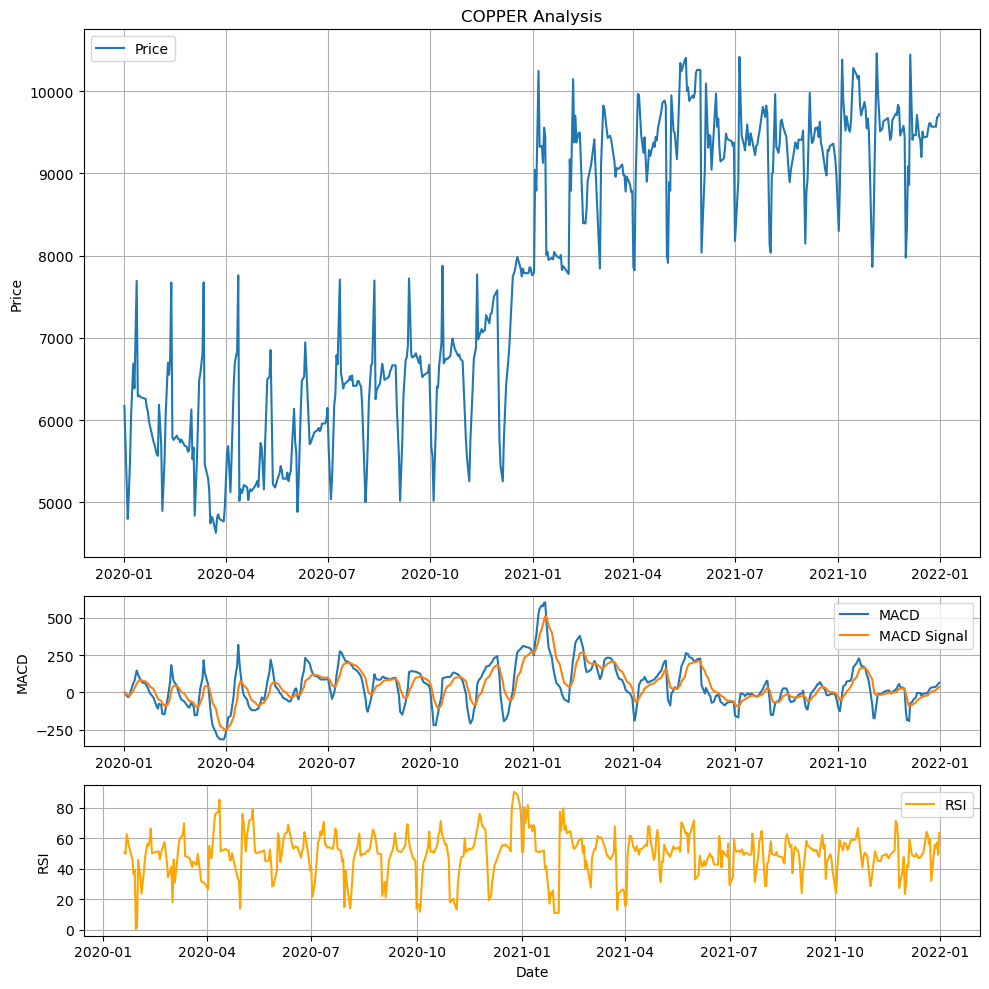

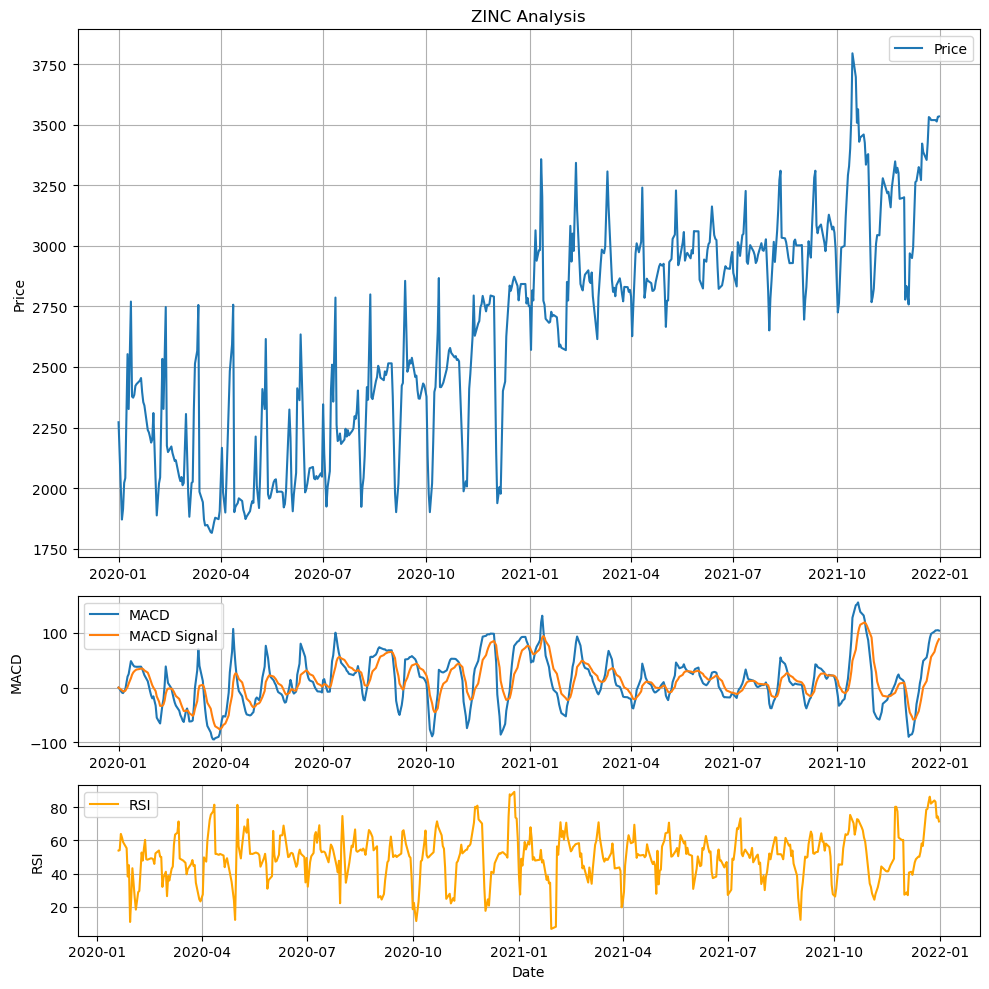

In [10]:
# Read CSV file and calculate MACD, RSI
csv_file = 'MarketData_filtered.csv'
df, metals = calculate_macd_rsi(csv_file)

# Plotting Price vs. MACD vs. RSI
plot_macd_rsi_price(df, metals)

# Populate SQL table with calculated data
populate_sql_table(df, metals)

We'll check the newly postulated data in the database.

In [12]:
prices = session.query(MetalPrice).all()
for price in prices:
    print(f"ID: {price.id}, Metal: {price.metal}, Date: {price.date}, Price: {price.price}, MACD: {price.macd}, MACD_signal: {price.macd_signal}, RSI: {price.rsi}")

ID: 1, Metal: COPPER, Date: 2020-01-01, Price: 6174.0, MACD: 0.0, MACD_signal: 0.0, RSI: None
ID: 2, Metal: ZINC, Date: 2020-01-01, Price: 2272.0, MACD: 0.0, MACD_signal: 0.0, RSI: None
ID: 3, Metal: COPPER, Date: 2020-01-04, Price: 4800.0, MACD: -30.826923076924686, MACD_signal: -17.12606837606927, RSI: None
ID: 4, Metal: ZINC, Date: 2020-01-04, Price: 1870.5, MACD: -9.008012820513159, MACD_signal: -5.004451566951754, RSI: None
ID: 5, Metal: COPPER, Date: 2020-01-05, Price: 5110.0, MACD: -29.66653728784968, MACD_signal: -22.26560481532353, RSI: None
ID: 6, Metal: ZINC, Date: 2020-01-05, Price: 1913.5, MACD: -10.144568878285781, MACD_signal: -7.111057022416519, RSI: None
ID: 7, Metal: COPPER, Date: 2020-01-06, Price: 5484.0, MACD: -14.90859202259071, MACD_signal: -19.773391809655234, RSI: None
ID: 8, Metal: ZINC, Date: 2020-01-06, Price: 2022.0, MACD: -6.495528051932524, MACD_signal: -6.902544498539828, RSI: None
ID: 9, Metal: COPPER, Date: 2020-01-07, Price: 6061.0, MACD: 16.384676001

In [13]:
# Close session
session.close()
engine.dispose()

# Improvements

[-] Implement methods to MetalPrice table structure. Currently, MACD and RSI fields are included in original structure in Question 2. Ideally, these fields need to be added to MetalPrice table in Question 3.

[-] Improve MACD and RSI algorithms in case data missing on a particular trading day.